In [4]:
import math
import numpy as np 
import sub_func
from sub_func import abs_dis, find_overlap
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from random import randrange
from IPython.display import clear_output
import os
from matplotlib import cm

from torch.nn.utils import clip_grad_norm_
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

# %matplotlib widget
%matplotlib inline

def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

def ele_list_gen(cr_c, mn_c, co_c, ni_c, num_c, mode = 'randchoice'):
    np.random.seed()

    assert abs(cr_c + mn_c + co_c + ni_c - 1) < 0.001, 'Make sure atomic ratio sum to 1'

    while True:
        if mode == 'randchoice':
            len_cr = randrange(int(cr_c*num_c),int(cr_c*num_c)+2)
            len_mn = randrange(int(mn_c*num_c),int(mn_c*num_c)+2)
            len_co = randrange(int(co_c*num_c),int(co_c*num_c)+2)
        elif mode == 'int':
            len_cr = int(cr_c*num_c)
            len_mn = int(mn_c*num_c)
            len_co = int(co_c*num_c)
        
        len_ni = num_c-len_cr-len_mn-len_co
        if abs(len_ni-num_c*ni_c) <= 1:
            break

    ele_list_raw = np.concatenate([np.zeros(len_cr)+2,np.ones(len_mn),0-np.ones(len_co),-1-np.ones(len_ni)],axis=0)
    np.random.shuffle(ele_list_raw)
    
    return ele_list_raw

def swap_step(action, state,):

    a1 = action[0]
    a2 = action[1]

    state[a2], state[a1] = state[a1], state[a2]

    return state

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

class CE:
    def __init__(self, ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
                ind_qua1nn, ind_qua1nn2nn,
                ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
                ind_raw):

        self.ind_1nn = ind_1nn
        self.ind_2nn = ind_2nn
        self.ind_3nn = ind_3nn
        self.ind_4nn = ind_4nn
        self.ind_qua1nn = ind_qua1nn
        self.ind_qua1nn2nn = ind_qua1nn2nn
        self.ind_trip1nn = ind_trip1nn
        self.ind_trip1nn2nn = ind_trip1nn2nn
        self.ind_trip1nn2nn3nn = ind_trip1nn2nn3nn
        self.ind_raw = ind_raw
        self.sym_oplist = np.array([2, 1, 1, 0, 6, 0, 4, 12, 24])
        self.sym_optri = np.array([6, 3, 1])
        self.sym_opqua = np.array([0, 0, 1, 0, 0, 0, 2, 0, 4])

    #*Normalizaiton by the symmetry operation for each cluster
    def sym_operator(self, cluster, mode='None'):
        if mode == 'None':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_oplist[mode_sym+mode_cluster-2]

        if mode == 'tri1nn':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_optri[mode_sym]
        
        if mode == 'qua1nn':
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            sym_op = self.sym_oplist[c_ind]

        if mode == 'qua1nn2nn':
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            single_list = np.array([2, 6, 8])
            if c_ind in single_list:
                sym_op = self.sym_opqua[c_ind]
            else:
                if c_ind == 4:
                    if len(np.unique(cluster[:2])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 1

                elif c_ind == 7:
                    if len(np.unique(cluster[:2])) == 2 and len(np.unique(cluster[2:4])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 2

        return sym_op

    def phi1(self, x):
        return 2/math.sqrt(10)*x

    def phi2(self, x):
        return -5/3 + 2/3*(x**2)

    def phi3(self, x):
        return -17/30*math.sqrt(10)*x + math.sqrt(10)/6*(x**3)
    
    #*Return the correlation function for each cluster
    def cpr(self, val_list):
        p1l = self.phi1(val_list).reshape(-1, 1)
        p2l = self.phi2(val_list).reshape(-1, 1)
        p3l = self.phi3(val_list).reshape(-1, 1)
        pl = np.concatenate([p1l, p2l, p3l], 1).T
        c_len = len(val_list)
        atom = 1
        for i in range(c_len):
            atom_1 = pl[:, i]
            atom = np.outer(atom_1, atom)

        return atom.flatten()

    def cluster_extra(self, config):
        cpr_1nn = 0
        for i in self.ind_1nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_1nn += self.cpr(cluster)/self.sym_operator(cluster)
        
        cpr_1nn /= len(self.ind_1nn)

        cpr_2nn = 0
        for i in self.ind_2nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_2nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_2nn /= len(self.ind_2nn)
        
        cpr_3nn = 0
        for i in self.ind_3nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_3nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_3nn /= len(self.ind_3nn)

        cpr_4nn = 0
        for i in self.ind_4nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_4nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_4nn /= len(self.ind_4nn)
            
        cpr_tri1nn = 0
        for i in self.ind_trip1nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')

        cpr_tri1nn /= len(self.ind_trip1nn)

        cpr_tri1nn2nn = 0
        for i in self.ind_trip1nn2nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            #*The only operation in this case when in AAB form
            if (a1 == a2 and a1 != a3) or (a1 == a3 and a1 != a2):
                cpr_tri1nn2nn += self.cpr(cluster)/2
            else:
                cpr_tri1nn2nn += self.cpr(cluster)

        cpr_tri1nn2nn /= len(self.ind_trip1nn2nn)

        cpr_tri1nn2nn3nn = 0
        for i in self.ind_trip1nn2nn3nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn2nn3nn += self.cpr(cluster)

        cpr_tri1nn2nn3nn /= len(self.ind_trip1nn2nn3nn)

        #!Consider the operation in qua later
        cpr_qua1nn = 0
        for i in self.ind_qua1nn:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn')

        cpr_qua1nn /= len(self.ind_qua1nn)

        cpr_qua1nn2nn = 0
        for i in self.ind_qua1nn2nn:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn2nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn2nn')

        cpr_qua1nn2nn /= len(self.ind_qua1nn2nn)

        return np.concatenate([
            cpr_1nn, cpr_2nn, cpr_3nn, cpr_4nn,
            cpr_tri1nn, cpr_tri1nn2nn, cpr_tri1nn2nn3nn,
            cpr_qua1nn,
        ], 0)

    def config_extra(self, num_cell, ind_cr, ind_mn, ind_co, ind_ni):
        ele_list = np.zeros(num_cell)
        overlap_cr = find_overlap(self.ind_raw, ind_cr)
        overlap_mn = find_overlap(self.ind_raw, ind_mn)
        overlap_co = find_overlap(self.ind_raw, ind_co)
        overlap_ni = find_overlap(self.ind_raw, ind_ni)

        ele_list[np.where(overlap_cr)[0]] = 2
        ele_list[np.where(overlap_mn)[0]] = 1
        ele_list[np.where(overlap_co)[0]] = -1
        ele_list[np.where(overlap_ni)[0]] = -2

        cpr_list = self.cluster_extra(ele_list)

        return cpr_list

    def read(self, incar_dir):
        with open(incar_dir) as f:
            input_strip = [s.strip() for s in f.readlines()]
        return input_strip

In [23]:
#* Deducing step
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn.npy')
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')

weight_list, energy = [], []
ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_qua1nn2nn,
        ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_raw)
atom_num = 32

for i in range(1, 315):
    ind_cr = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_cr_chosen.npy')
    ind_mn = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_mn_chosen.npy')
    ind_co = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_co_chosen.npy')
    ind_ni = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_ni_chosen.npy')
    osz_dir = f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Cr25Mn25Co25Ni25_3.512_try{i}/OSZICAR'
    oszicar = ce_.read(osz_dir)[-1]
    e_ground = float(''.join(oszicar).split()[-4])
    ce_feature = ce_.config_extra(atom_num, ind_cr, ind_mn, ind_co, ind_ni)
    weight_list.append(ce_feature)
    energy.append(e_ground)

weight_list, energy = np.array(weight_list), np.array(energy)/atom_num
#* Normalization
# energy_min, energy_max = np.min(energy), np.max(energy)
energy_std = np.std(energy)
energy_mean = np.mean(energy)
energy = (energy - energy_mean)

# weight_std = np.std(weight_list, axis=0)
# weight_mean = np.mean(weight_list, axis=0)
# weight_list = (weight_list - weight_mean) / weight_std

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
weight_list = torch.from_numpy(weight_list.astype(np.float32)).clone()
energy = torch.from_numpy(energy.astype(np.float32)).clone()
weight_list = weight_list.to(device)
energy = energy.reshape(-1,1).to(device)

e_train, e_test, weight_train, weight_test = train_test_split(
    energy, weight_list, test_size=0.1)

In [36]:
#*Linear regression
weight_train_, e_train_ = weight_train.clone(), e_train.clone()
weight_test_, e_test_ = weight_test.clone(), e_test.clone()

clf_ = BayesianRidge().fit(weight_train_.detach().cpu().numpy(), e_train_.detach().cpu().numpy().flatten())
e_predict_lr = clf_.predict(weight_test_.detach().cpu().numpy())

In [67]:
#* FC part
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class fc(nn.Module):
    def __init__(self, state_dim):
        super(fc, self).__init__()

        self.state_dim = state_dim
        self.output = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(128, 1),
        )

    def forward(self, s_a):
        
        e_ = self.output(s_a)

        return e_

In [68]:
#* Training step
state_dim = 198
mini_batchsize = 16
lr_ = 1e-5
train_step = 1000000
epoch_per_episode = 16
path_save = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo'

#*Device is defined in former block
fc_ = fc(state_dim).to(device)
fc_optim = torch.optim.Adam(fc_.parameters(), lr = lr_)
scheduler = torch.optim.lr_scheduler.StepLR(fc_optim,step_size=10000,gamma = 0.98)
mse_loss = nn.MSELoss()
writer = SummaryWriter(log_dir = path_save)
torch.manual_seed(886)

for i in range(train_step):
    # for index in BatchSampler(SubsetRandomSampler(range(len(weight_train))), mini_batchsize, True):
        # for epoch in range(epoch_per_episode):
    fc_.train()
    weight_train_ = weight_train
    e_train_ = e_train
    e_out_train = fc_(weight_train_)
    e_tar_train = e_train_
    e_loss_train = mse_loss(e_out_train, e_tar_train)

    writer.add_scalar("Training Loss", e_loss_train, i)

    fc_optim.zero_grad()
    e_loss_train.backward()
    clip_grad_norm_(fc_.parameters(), 1)
    fc_optim.step()
    scheduler.step()

    fc_.eval()
    e_out_test = fc_(weight_test)
    e_loss_test = mse_loss(e_out_test, e_test)
    writer.add_scalar("Testing Loss", e_loss_test, i)

KeyboardInterrupt: 

In [54]:
np.linalg.norm(nn_res)/len(nn_res)

0.008518179878592491

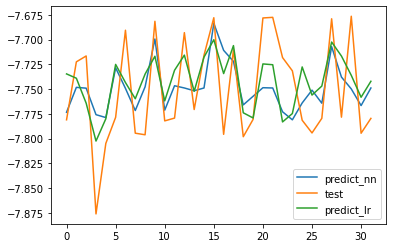

In [69]:
fc_.eval()
energy_std = 1
e_predict = fc_(weight_test).cpu().detach().numpy()*energy_std + energy_mean
e_test_ = e_test.cpu().detach().numpy()*energy_std + energy_mean
e_predict_lr_ = e_predict_lr*energy_std + energy_mean

plt.plot(e_predict, label='predict_nn')
plt.plot(e_test_, label='test')
plt.plot(e_predict_lr_, label='predict_lr')

plt.legend()
plt.show()

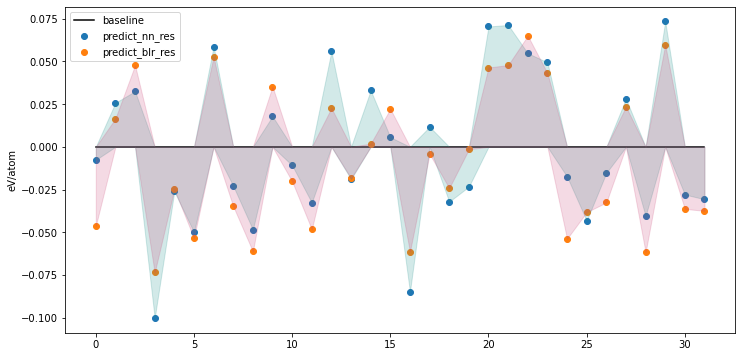

In [70]:
nn_res = (e_test_ - e_predict)
lr_res = (e_test_ - e_predict_lr_.reshape(-1,1))
r_nn_u = np.clip(nn_res, 0, None).flatten()
r_nn_l = np.clip(nn_res, None, 0).flatten()
r_lr_u = np.clip(lr_res, 0, None).flatten()
r_lr_l = np.clip(lr_res, None, 0).flatten()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('eV/atom')
x_axis = np.arange(len(e_test_))
plt.scatter(x_axis, nn_res, label='predict_nn_res')
plt.scatter(x_axis, lr_res, label='predict_blr_res')
plt.plot(x_axis, np.zeros(len(e_test)), c='k', label='baseline', zorder=0)
plt.fill_between(x_axis, r_nn_l, r_nn_u, 
            alpha=0.2, color=cm.viridis(0.5))
plt.fill_between(x_axis, r_lr_l, r_lr_u, 
            alpha=0.2, color=cm.plasma(0.5))

plt.legend()
plt.show()

In [71]:
pth_save = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221031'
torch.save(fc_.state_dict(), pth_save+'/param.pth')

In [ ]:
import shutil
shutil.copy('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/cluster_nn.ipynb',
    pth_save+'/cluster_nn.ipynb')

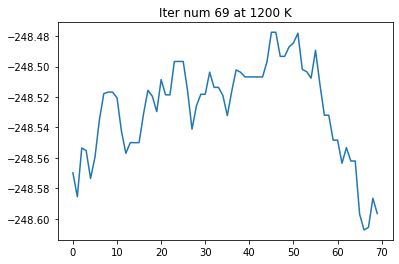

KeyboardInterrupt: 

In [35]:
#* Estimation step
fc_.eval()

def norm_w(x, x_mean, x_std):
        return (x - x_mean) / x_std

ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn3nn.npy')
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_raw2048.npy')

ce_e = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_qua1nn2nn,
        ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_raw)

config = ele_list_gen(1/4, 1/4, 1/4, 1/4, num_c=2048)
iter_time= 1000
temp = 
k_ = 8.617333262e-5
e_list = []
atom_num = 2048
config_list = np.zeros((50, atom_num))
e_list_store = np.zeros(50)
for i in range(iter_time):

        # weight_config = norm_w(ce_e.cluster_extra(config).reshape(-1,1).T,
        #                 weight_mean, weight_std)
        weight_config  =ce_e.cluster_extra(config).reshape(-1,1).T
        weight_config = torch.from_numpy(weight_config.astype(np.float32)).clone().to(device)
        energy = fc_(weight_config).cpu().detach().numpy()[0,0]*energy_std + energy_mean
        energy *= atom_num
        e_list.append(energy)
        config_list[iter_time%50] = config
        e_list_store[iter_time%50] = energy

        a_ind = randrange(len(ind_1nn))
        action = ind_1nn[a_ind]
        config_ = swap_step(action, config)
        # weight_config_ = norm_w(ce_e.cluster_extra(config_).reshape(-1,1).T,
        #                 weight_mean, weight_std)
        weight_config_ = ce_e.cluster_extra(config_).reshape(-1,1).T
        weight_config_ = torch.from_numpy(weight_config_.astype(np.float32)).clone().to(device)
        energy_ = fc_(weight_config_).cpu().detach().numpy()[0,0]*energy_std + energy_mean
        energy_ *= atom_num

        accept = np.min([1, np.exp((energy-energy_)/(k_*temp))])
        r_v = np.random.rand()
        if r_v <= accept:
                config = config_
        else:
                config = config

        clear_output(True)
        plt.title(f'Iter num {i} at {temp} K')
        plt.plot(e_list)
        plt.show()

In [20]:
fc_

fc(
  (output): Sequential(
    (0): Linear(in_features=198, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)